## Package Installaion

In [17]:
%pip install statsmodels


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
%pip install neuralprophet
%pip install matplotlib
%pip install seaborn
%pip install pickle


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Package Importation

In [19]:
from neuralprophet import NeuralProphet, set_random_seed, set_log_level; set_random_seed(314159); set_log_level("ERROR", "INFO")
from neuralprophet.df_utils import make_future_df, fill_linear_then_rolling_avg, add_missing_dates_nan

import pandas as pd
import numpy as np

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True); sns.set_style("whitegrid")

import time

from collections import defaultdict

import copy

import pickle

## Reading Data

Below we read in the data for train, val and test as well as the associated historical dataframe

In [20]:
df = pd.read_csv('../data_processing/final_dataset/5_year.csv', index_col=0)

In [21]:
train = pd.read_csv('../data_processing/train_final.csv', index_col=0).T
val = pd.read_csv('../data_processing/val_final.csv', index_col=0).T
test = pd.read_csv('../data_processing/test_final.csv', index_col=0).T

In [22]:
base_model = NeuralProphet(
    growth='discontinuous',  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=52, # Number of weeks in a month, looks at a potential changepoint evey month
    trend_reg=0, # Changed to 0 for no flexibility in selection of changepoints
    trend_reg_threshold=False, # Requires regularization for trend to be changed
    yearly_seasonality=True, # Automatically fits yearly seasonality
    weekly_seasonality='auto', # Automatically fits weekly seasonality
    daily_seasonality='auto', # Automatically fits daily seasonality
    seasonality_mode='additive', # Additional (adds) seasonality instead of multiplicative (multiplies) seasonality
    seasonality_reg=0, # Due to the dataset being based on bike shares, visually will be very impacted by seasonality: set at maximum
    n_forecasts=1, # Set at default 1 for forecasting one step ahead
    n_lags=7, # To include 7 days worth of AR lag
    num_hidden_layers=4, # 8 hidden layers for the network
    d_hidden=32, # Dimension of hidden layers of AR-Net
    learning_rate=0.01, # Automatically determines learning rate
    epochs=None, # Automatically sets the learning rate (based on data size)
    loss_func='Huber', # Sets Huber loss function for robustness to outliers ### Describe Huber in presentation/write-up
    # normalize='auto',  # Type of normalization ('minmax', 'standardize', 'soft', 'auto', None) ## Why normalize again?
)

In [23]:
industry_symbol = df['Symbol']

In [24]:
index_to_symbol_map = industry_symbol.to_dict()
symbol_to_index_map = dict(zip(index_to_symbol_map.values(), index_to_symbol_map.keys()))

In [25]:
for symbol in industry_symbol:

    set_random_seed(0)
    model = copy.deepcopy(base_model)

    train_inp = pd.DataFrame(train[symbol_to_index_map[symbol]])
    train_inp=train_inp.reset_index()
    train_inp=train_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
    val_inp = pd.DataFrame(val[symbol_to_index_map[symbol]])
    val_inp=val_inp.reset_index()
    val_inp=val_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
    metrics = model.fit(train_inp,freq="D", validation_df= val_inp)
    ## Pickling model and metrics
    model_path = '../model/model_ar/' + symbol +'_model.pickle'
    metrics_path = '../model/metrics_ar/' + symbol+'_metric.pickle'


    with open(model_path, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(metrics_path, 'wb') as handle:
        pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/180 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

  0%|          | 0/180 [00:00<?, ?it/s]                                                                                                                                                        WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the sam

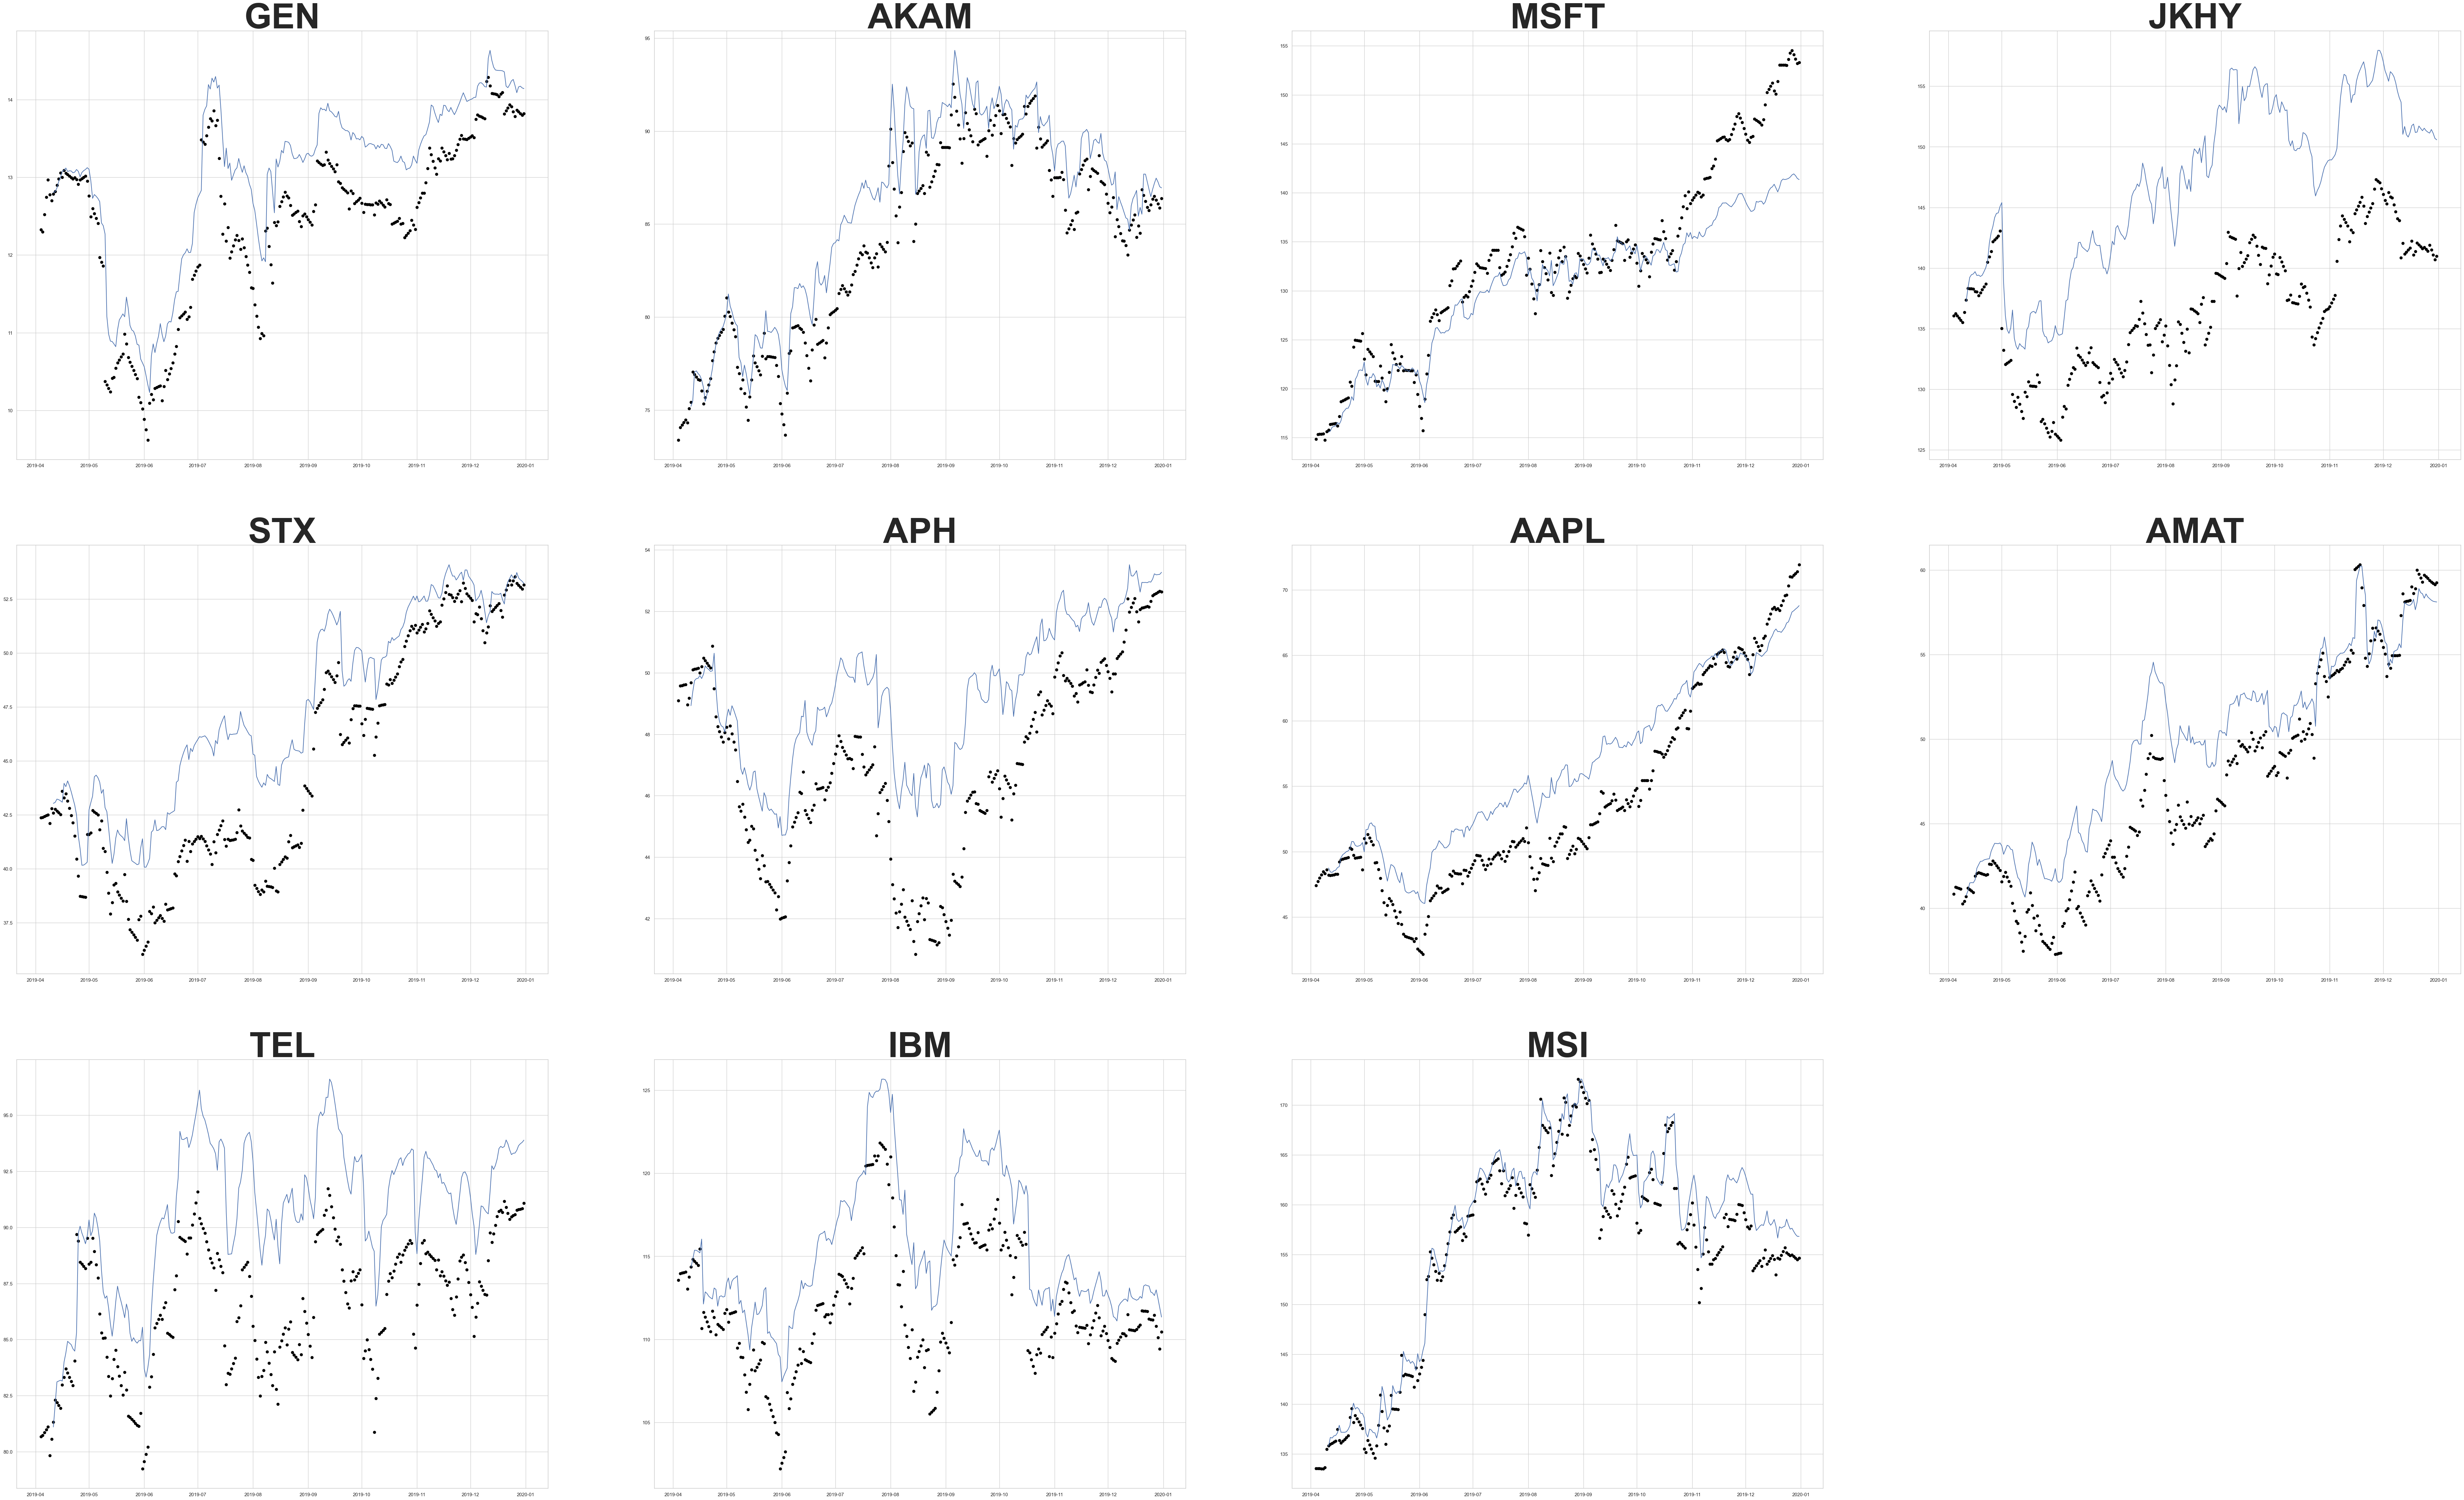

In [37]:
fig, ax = plt.subplots(3,4 , figsize = (100,60))


# industry_symbol['Symbol'/]
for i in range(3):
    for j in range(4):
        ind = 4*i + j 
        if ind == len(industry_symbol):
            break
        symbol = industry_symbol[ind]
        filename = '../model/model_ar/'+symbol+'_model.pickle'
        model = pickle.load(open(filename, 'rb'))
        test_inp = pd.DataFrame(test[symbol_to_index_map[symbol]])
        test_inp=test_inp.reset_index()
        test_inp=test_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
        future = model.make_future_dataframe(df=test_inp, periods=365, n_historic_predictions=len(test_inp))
        forecast = model.predict(df=test_inp)
        ax[i,j].scatter(forecast['ds'],forecast['y'], c = 'black')
        ax[i,j].plot(forecast['ds'],forecast['yhat1'])
        ax[i,j].set_title(symbol,fontweight='bold', size=80)
ax[2,3].axis('off')
plt.show()

In [27]:
for symbol in industry_symbol: # Loop over symbols
    filename = '../model/model_ar/'+symbol+'_model.pickle' # might wanna change this
    model = pickle.load(open(filename, 'rb'))
    test_inp = pd.DataFrame(test[symbol_to_index_map[symbol]])
    test_inp=test_inp.reset_index()
    test_inp=test_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
    future = model.make_future_dataframe(df=test_inp, periods=365, n_historic_predictions=len(test_inp))
    forecast = model.predict(df=test_inp)
    rmse = np.average(forecast['residual1'][7:]**2)**(1/2)
    mae = np.average(np.abs(forecast['residual1'][7:]))
    print(symbol, ':', rmse, mae)

GEN : 0.6817855807882236 0.6180909732602676
AKAM : 2.161963731185735 1.7959588824578052
MSFT : 4.4818774467544005 3.134057406059602
JKHY : 10.76242732347969 10.14060942451909
STX : 3.1566248431921022 2.695189026166808
APH : 2.778710398970955 2.488049899407153
AAPL : 3.3375266293435097 2.9175283180092864
AMAT : 3.2300243121278243 2.7485242087886017
TEL : 4.472217219616502 4.159446241270821
IBM : 3.9698863076129114 3.5898055454470073
MSI : 2.66908610346821 2.1207155815460395


In [28]:
r = []
m = []
i= 0
for symbol in industry_symbol: # Loop over symbols
    i +=1
    filename = '../model/model_ar/'+symbol+'_model.pickle' # might wanna change this
    model = pickle.load(open(filename, 'rb'))
    test_inp = pd.DataFrame(test[symbol_to_index_map[symbol]])
    test_inp=test_inp.reset_index()
    test_inp=test_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
    future = model.make_future_dataframe(df=test_inp, periods=365, n_historic_predictions=len(test_inp))
    forecast = model.predict(df=test_inp)
    rmse = np.average(forecast['residual1'][7:]**2)**(1/2)
    mae = np.average(np.abs(forecast['residual1'][7:]))
    print(symbol, ':', rmse, mae)
    r.append(rmse)
    m.append(mae)


print('avg_rmse:' , sum(r)/i)
print('avg_mae:',  sum(m)/i)

GEN : 0.6817855807882236 0.6180909732602676
AKAM : 2.161963731185735 1.7959588824578052
MSFT : 4.4818774467544005 3.134057406059602
JKHY : 10.76242732347969 10.14060942451909
STX : 3.1566248431921022 2.695189026166808
APH : 2.778710398970955 2.488049899407153
AAPL : 3.3375266293435097 2.9175283180092864
AMAT : 3.2300243121278243 2.7485242087886017
TEL : 4.472217219616502 4.159446241270821
IBM : 3.9698863076129114 3.5898055454470073
MSI : 2.66908610346821 2.1207155815460395
avg_rmse: 3.7911027178672785
avg_mae: 3.30981595517568


In [29]:
for symbol in industry_symbol: # Loop over symbols
    filename = '../model/metrics_ar/'+symbol+'_metric.pickle' # might wanna change this
    metrics = pickle.load(open(filename, 'rb'))
    print(symbol,':', list(metrics['RMSE_val'])[-1],list(metrics['MAE_val'])[-1] )

GEN : 1.4171595573425293 1.257108211517334
AKAM : 9.775551795959473 7.298680782318115
MSFT : 15.021032333374023 12.171188354492188
JKHY : 17.041244506835938 14.069913864135742
STX : 5.4184184074401855 4.493556022644043
APH : 3.9579944610595703 3.2841293811798096
AAPL : 8.025442123413086 6.841036319732666
AMAT : 6.766000270843506 5.722188472747803
TEL : 6.9654693603515625 5.722609996795654
IBM : 9.19257926940918 7.470395088195801
MSI : 8.406900405883789 7.033477783203125


In [30]:
np.max(forecast['residual1'])

8.199737548828125

In [31]:
metrics

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.740611,78.463528,101.976708,0.582093,0.0,0.644647,73.120766,92.731407
1,0.602251,67.784588,89.676273,0.462361,0.0,0.605524,69.723953,89.020386
2,0.540497,62.799095,83.229862,0.409241,0.0,0.577488,67.211090,86.336395
3,0.512385,60.489095,79.189246,0.385595,0.0,0.556332,65.362495,84.304222
4,0.494646,59.091495,77.187450,0.371647,0.0,0.540875,64.219215,82.871109
...,...,...,...,...,...,...,...,...
175,0.000088,0.593225,0.858815,0.000075,0.0,0.007459,7.031768,8.405623
176,0.000087,0.592488,0.856074,0.000074,0.0,0.007463,7.034622,8.408264
177,0.000087,0.591927,0.851501,0.000074,0.0,0.007459,7.032409,8.405635
178,0.000087,0.591305,0.858984,0.000074,0.0,0.007461,7.033493,8.406941


In [32]:
symbol = 'GEN'
filename = '../model/model_ar/'+symbol+'_model.pickle' # might wanna change this
model = pickle.load(open(filename, 'rb'))
val_inp = pd.DataFrame(val[symbol_to_index_map[symbol]])
val_inp=val_inp.reset_index()
val_inp=val_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
forecast = model.predict(df=val_inp)
rmse = np.average(forecast['residual1'][7:]**2)**(1/2)
mae = np.average(np.abs(forecast['residual1'][7:]))
print(symbol, ':', rmse, mae)

GEN : 1.4228886860328478 1.2049008032214958


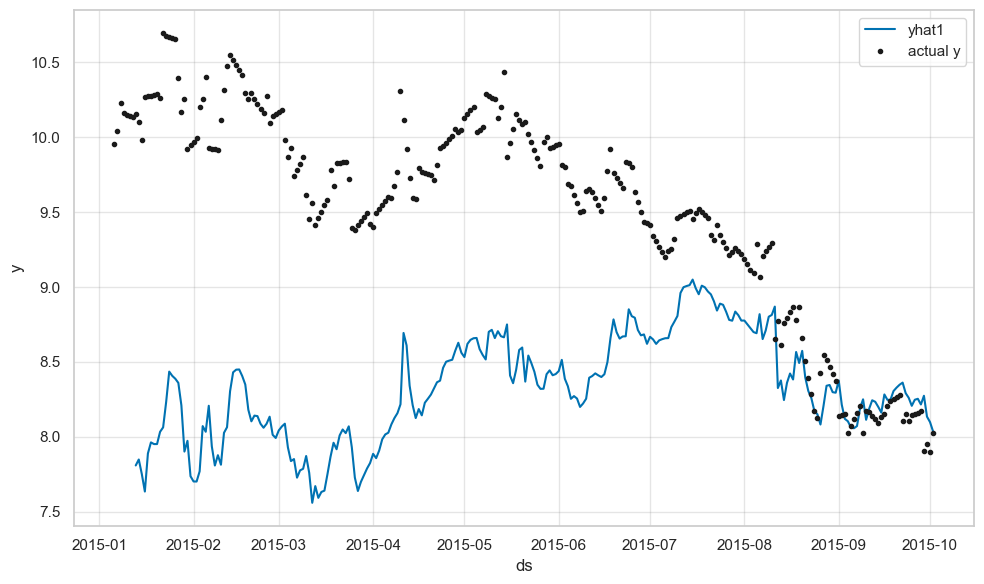

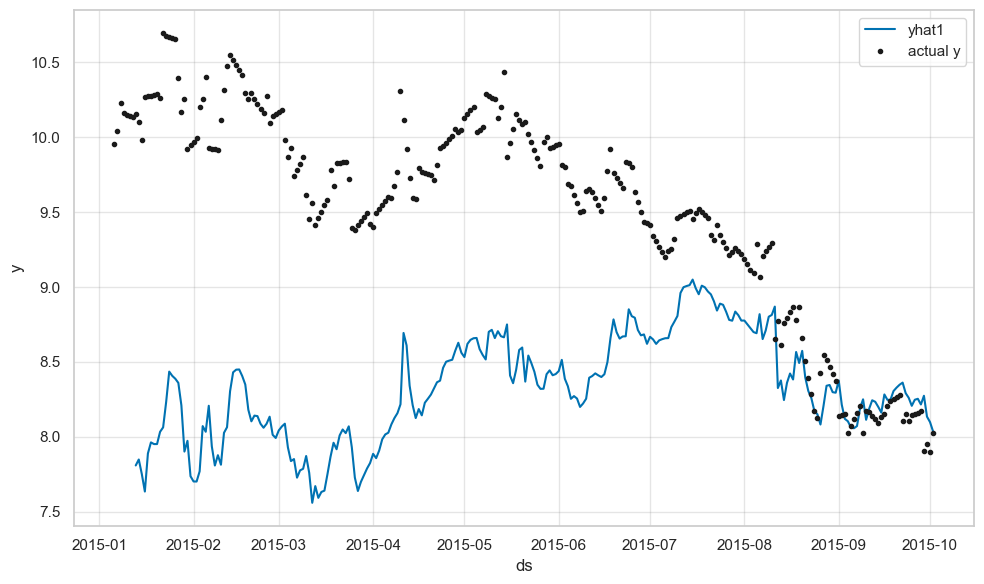

In [33]:
model.plot(forecast)

In [34]:
forecast

,ds,y,residual1,yhat1,ar1,trend,season_yearly,season_weekly
0,2015-01-06,9.952563,NaN,None,None,None,None,None
1,2015-01-07,10.044714,NaN,None,None,None,None,None
2,2015-01-08,10.229023,NaN,None,None,None,None,None
3,2015-01-09,10.160909,NaN,None,None,None,None,None
4,2015-01-10,10.151560,NaN,None,None,None,None,None
...,...,...,...,...,...,...,...,...
265,2015-09-28,8.170021,0.046049,8.21607,1.368295,6.656451,0.196317,-0.004993
266,2015-09-29,7.904493,0.369623,8.274117,1.421273,6.661766,0.188275,0.002802
267,2015-09-30,7.953515,0.181319,8.134833,1.261033,6.66708,0.179836,0.026884
268,2015-10-01,7.896327,0.201909,8.098235,1.247484,6.672395,0.171053,0.007303


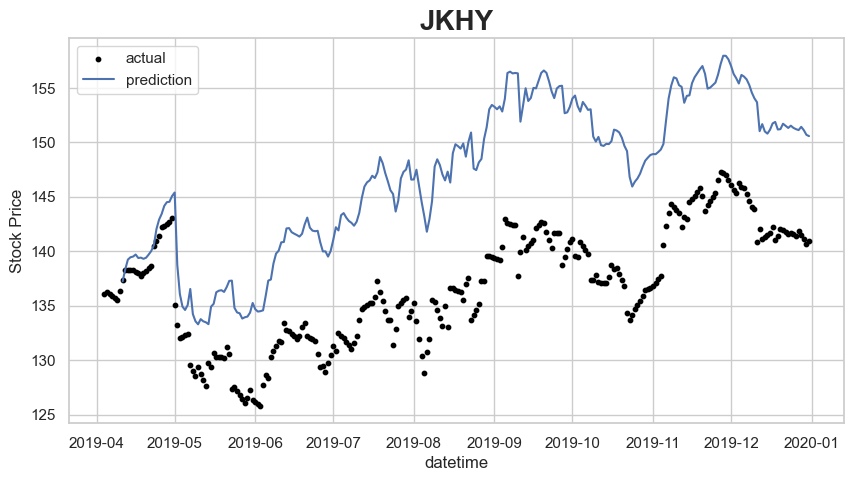

In [35]:
symbol = 'JKHY'
# symbol = industry_symbol[ind]
filename = '../model/model_ar/'+symbol+'_model.pickle'
model = pickle.load(open(filename, 'rb'))
test_inp = pd.DataFrame(test[symbol_to_index_map[symbol]])
test_inp=test_inp.reset_index()
test_inp=test_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
future = model.make_future_dataframe(df=test_inp, periods=365, n_historic_predictions=len(test_inp))
forecast = model.predict(df=test_inp)
plt.figure(figsize=(10,5))
plt.scatter(forecast['ds'],forecast['y'], c = 'black', s = 10)
plt.plot(forecast['ds'],forecast['yhat1'])
plt.legend(['actual', 'prediction'])
plt.title(symbol,fontweight='bold', size=20)
plt.xlabel('datetime') 
plt.ylabel('Stock Price') 


plt.show()

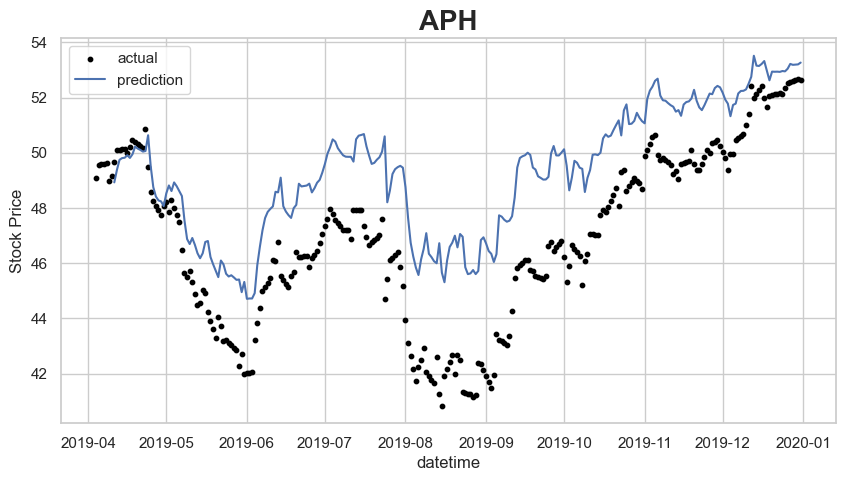

In [36]:
symbol = 'APH'
# symbol = industry_symbol[ind]
filename = '../model/model_ar/'+symbol+'_model.pickle'
model = pickle.load(open(filename, 'rb'))
test_inp = pd.DataFrame(test[symbol_to_index_map[symbol]])
test_inp=test_inp.reset_index()
test_inp=test_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
future = model.make_future_dataframe(df=test_inp, periods=365, n_historic_predictions=len(test_inp))
forecast = model.predict(df=test_inp)
plt.figure(figsize=(10,5))
plt.scatter(forecast['ds'],forecast['y'], c = 'black', s = 10)
plt.plot(forecast['ds'],forecast['yhat1'])
plt.legend(['actual', 'prediction'])
plt.title(symbol,fontweight='bold', size=20)
plt.xlabel('datetime') 
plt.ylabel('Stock Price') 


plt.show()